# Cognition and Computation Project

## Import Libraries

In [1]:
import math
import os

from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import scipy
import pandas as pd
import numpy as np

## Restricted Boltzmann Machine

In [26]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden, k=1):
        super(RBM, self).__init__()

        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.k = k

    @torch.no_grad()
    def sample_h(self, v):
        prob_h = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return prob_h, torch.bernoulli(prob_h)

    @torch.no_grad()
    def sample_v(self, h):
        prob_v = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return prob_v, torch.bernoulli(prob_v)

    @torch.no_grad()
    def reconstruct(self, v, return_sample=False):
        prob_h, h = self.sample_h(v)
        prob_v_rec, v_rec = self.sample_v(h if return_sample else prob_h)
        return prob_v_rec, v_rec

    def free_energy(self, v):
        vbias_term = v @ self.v_bias
        hidden_term = torch.sum(
            F.softplus(v @ self.W.t() + self.h_bias),
            dim=1
        )
        return -vbias_term - hidden_term

    @torch.no_grad()
    def gibbs_k(self, v):
        prob_h, h = self.sample_h(v)
        prob_v = None
        for _ in range(self.k):
            prob_v, v = self.sample_v(h)
            prob_h, h = self.sample_h(v)
        return prob_v, v

    def fit(self, dataset, learning_rate=0.001, epochs=5, batch_size=32, device=None):
        self.to(device)
        dataset = dataset.to(device)
        n = len(dataset)

        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        recon_loss_history = []
        for epoch in range(epochs):
            epoch_recon_loss_history = []

            shuffle = torch.randperm(n, device=device)

            for start in range(0, n, batch_size):
                i = shuffle[start:start+batch_size]
                v0 = dataset[i]

                prob_v, v = self.gibbs_k(v0)

                loss = (self.free_energy(v0) - self.free_energy(v)).mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                recon_loss = F.mse_loss(v0, prob_v).item()
                epoch_recon_loss_history.append(recon_loss)

            epoch_recon_loss = float(np.mean(epoch_recon_loss_history))
            recon_loss_history.append(epoch_recon_loss)

            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f'Epoch {epoch+1}/{epochs}, MSE: {epoch_recon_loss:.6f}')

        return recon_loss_history

## Deep Belief Network

In [ ]:
class DBN(nn.Module):
    def __init__(self, n_visible, n_hidden=[], k=1):
        super(DBN, self).__init__()

        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.k = k

        sizes = [n_visible] + self.n_hidden
        self.rbms = nn.ModuleList([
            RBM(n_visible=sizes[i], n_hidden=sizes[i + 1], k=k)
            for i in range(len(sizes) - 1)
        ])

    @torch.no_grad()
    def encode(self, v, return_samples=False):
        """Forward pass"""
        x = v
        for rbm in self.rbms:
            prob_h, h = rbm.sample_h(x)
            x = h if return_samples else prob_h
        return prob_h, h

    @torch.no_grad()
    def decode(self, h, return_samples=False):
        """Backward (generative) pass"""
        x = h
        for rbm in reversed(self.rbms):
            prob_v, v = rbm.sample_v(x)
            x = v if return_samples else prob_v
        return prob_v, v

    @torch.no_grad()
    def reconstruct(self, v, return_samples=False):
        prob_h, h = self.encode(v, return_samples=return_samples)
        prob_v_rec, v_rec = self.decode(
            h if return_samples else prob_h, return_samples=return_samples
        )
        return prob_v_rec, v_rec

    def fit(self, dataset, learning_rate=0.001, epochs=5, batch_size=32, device=None, sample_mode=False):
        x = dataset.to(device)

        histories = []
        for layer_idx, rbm in enumerate(self.rbms):
            print(
                f"Pretraining layer {layer_idx+1}/{len(self.rbms)}: ({rbm.W.shape[1]} -> {rbm.W.shape[0]})"
            )

            hist = rbm.fit(
                dataset=x,
                learning_rate=learning_rate,
                epochs=epochs,
                batch_size=batch_size,
                device=device
            )
            histories.append(hist)

            with torch.no_grad():
                prob_h, h = rbm.sample_h(x)
                x = h if sample_mode else prob_h

        return histories

## Utils functions

In [ ]:
def normalize_float(data):
    return data.to(torch.float32) / 255.0


def show_img(img, digit=None):
    if digit is not None:
        print(f'The image shows the digit: {digit}')
    img = img.cpu()
    plt.imshow(img, cmap='gray')
    plt.show()


def compare_imgs(imgs, digit):
    print(f'The images show the digit: {digit}')
    n_imgs = len(imgs)
    for i, img in enumerate(imgs):
        img = img.cpu()
        plt.subplot(1, n_imgs, i+1)
        plt.imshow(img, cmap='gray')
    plt.show()

## Training on MNIST

In [29]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

print(f'Using device: {device_name}')

Using device: cuda


In [30]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
])

mnist_train_ds = torchvision.datasets.MNIST(
    root='mnist', train=True, download=True, transform=transforms
)
mnist_test_ds = torchvision.datasets.MNIST(
    root='mnist', train=False, download=True, transform=transforms
)

mnist_img_shape = (28, 28)
batch_size = 32

mnist_train_loader = DataLoader(
    mnist_train_ds, batch_size=batch_size, shuffle=True
)
mnist_test_loader = DataLoader(
    mnist_test_ds, batch_size=batch_size, shuffle=False
)

The image shows the digit: 5


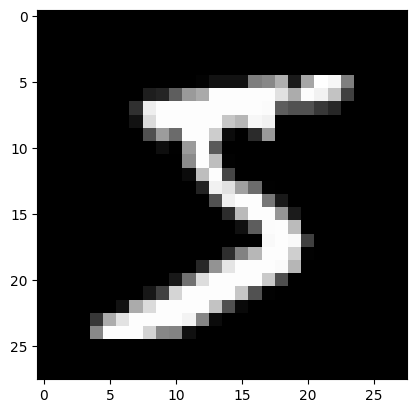

In [31]:
idx = 0
img, digit = mnist_train_ds[idx]

show_img(img.reshape(mnist_img_shape), digit)

In [8]:
print(f'Training dataset size: {len(mnist_train_loader)}')
print(f'Test dataset size: {len(mnist_test_loader)}')

Training dataset size: 60000
Test dataset size: 10000


In [32]:
# Initialize RBM
n_visible = mnist_img_shape[0] * mnist_img_shape[1]
n_hidden = 128

rbm = RBM(
    n_visible=n_visible,
    n_hidden=n_hidden,
    k=1
)

rbm.to(device)

rbm_weights_file_name = 'rbm_1.pth'

In [33]:
# RBM training
train_data = normalize_float(
    mnist_train_ds.data.reshape(len(mnist_train_ds), n_visible)
)

loss_history = rbm.fit(
    dataset=train_data,
    learning_rate=0.001,
    epochs=50,
    batch_size=batch_size,
    device=device
)

Epoch 1/50, MSE: 0.045182
Epoch 11/50, MSE: 0.014483
Epoch 21/50, MSE: 0.013041
Epoch 31/50, MSE: 0.012516
Epoch 41/50, MSE: 0.012235
Epoch 50/50, MSE: 0.012082


In [34]:
# Saving RBM weights to file
torch.save(rbm.state_dict(), rbm_weights_file_name)
print(f'RBM model weights saved to "{rbm_weights_file_name}"')

RBM model weights saved to "rbm_1.pth"


In [63]:
# Downloading weights
%%capture
!wget -O {rbm_weights_file_name} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{rbm_weights_file_name}"

In [50]:
# Loading weights from file
rbm.load_state_dict(torch.load(rbm_weights_file_name, map_location=device))
print(f'RBM model weights loaded from "{rbm_weights_file_name}"')

RBM model weights loaded from "rbm_1.pth"


The images show the digit: 0


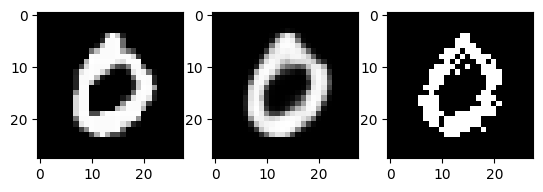

In [ ]:
test_idx = 3
test_img_raw = normalize_float(mnist_test_ds.data[test_idx])
test_digit = mnist_test_ds.targets[test_idx].to(device)

_prob_v, _v = rbm.reconstruct(test_img_raw.reshape(1, n_visible).to(device), return_sample=False)
reconstruct_prob_img = _prob_v.reshape(mnist_img_shape).detach()
reconstruct_img = _v.reshape(mnist_img_shape).detach()

compare_imgs([test_img_raw.reshape(mnist_img_shape), reconstruct_prob_img, reconstruct_img], test_digit)

In [37]:
# Initialize DBN
dbn = DBN(
    n_visible=n_visible,
    n_hidden=[400, 500, 800],
    k=1
)

dbn.to(device)

dbn_weights_file_name = 'dbn_1.pth'

In [38]:
# DBN training
train_data = normalize_float(
    mnist_train_ds.data.reshape(len(mnist_train_ds), n_visible)
)

dbn_loss_histories = dbn.fit(
    dataset=train_data,
    learning_rate=0.001,
    epochs=50,
    batch_size=batch_size,
    device=device,
    sample_mode=False,
)

Pretraining layer 1/3: (784 -> 400)
Epoch 1/50, MSE: 0.034785
Epoch 11/50, MSE: 0.009599
Epoch 21/50, MSE: 0.008977
Epoch 31/50, MSE: 0.008726
Epoch 41/50, MSE: 0.008599
Epoch 50/50, MSE: 0.008517
Pretraining layer 2/3: (400 -> 500)
Epoch 1/50, MSE: 0.048819
Epoch 11/50, MSE: 0.010539
Epoch 21/50, MSE: 0.009643
Epoch 31/50, MSE: 0.009390
Epoch 41/50, MSE: 0.009272
Epoch 50/50, MSE: 0.009240
Pretraining layer 3/3: (500 -> 800)
Epoch 1/50, MSE: 0.030998
Epoch 11/50, MSE: 0.006364
Epoch 21/50, MSE: 0.005793
Epoch 31/50, MSE: 0.005619
Epoch 41/50, MSE: 0.005525
Epoch 50/50, MSE: 0.005485


In [39]:
# Saving DBN weights to file
torch.save(dbn.state_dict(), dbn_weights_file_name)
print(f'DBN model weights saved to "{dbn_weights_file_name}"')

DBN model weights saved to "dbn_1.pth"


In [67]:
# Downloading weights
%%capture
!wget -O {dbn_weights_file_name} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{dbn_weights_file_name}"

In [68]:
# Loading weights from file
dbn.load_state_dict(torch.load(dbn_weights_file_name, map_location=device))
print(f'DBN model weights loaded from "{dbn_weights_file_name}"')

DBN model weights loaded from "dbn_1.pth"


The images show the digit: 0


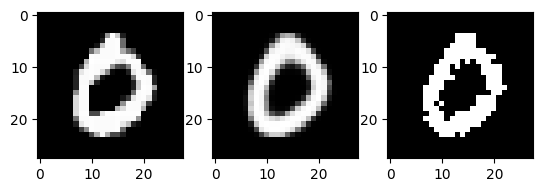

In [ ]:
test_idx = 3
test_img_raw = normalize_float(mnist_test_ds.data[test_idx])
test_digit = mnist_test_ds.targets[test_idx].to(device)

_prob_v, _v = dbn.reconstruct(test_img_raw.reshape(1, n_visible).to(device))
reconstruct_prob_img = _prob_v.reshape(mnist_img_shape).detach()
reconstruct_img = _v.reshape(mnist_img_shape).detach()

compare_imgs([test_img_raw.reshape(mnist_img_shape), reconstruct_prob_img, reconstruct_img], test_digit)

## Visualizing receptive fields

In [41]:
def get_rbm_weights(rbm):
    return rbm.W.detach().cpu().numpy()


def apply_threshold(weights, threshold):
    return weights * (np.abs(weights) > threshold)


def apply_min_max_scaler(weights):
    shape = weights.shape
    scaler = MinMaxScaler()
    weights = scaler.fit_transform(weights.ravel().reshape(-1, 1))
    weights = weights.reshape(shape)
    return weights


def plot_layer_receptive_fields(weights):
    n_filters = 100
    n_cols = n_rows = int(math.sqrt(n_filters))
    fig, axs = plt.subplots(
        n_rows, n_cols,
        sharex=True, sharey=True, figsize=(15, 15)
    )

    for i in range(n_filters):
        row = i // n_cols
        col = i % n_cols
        axs[row, col].imshow(
            weights[:, i].reshape(mnist_img_shape),
            cmap="gray"
        )
        axs[row, col].axis("off")

    plt.tight_layout()
    display(fig)
    plt.close(fig)

======= Layer 1 =======


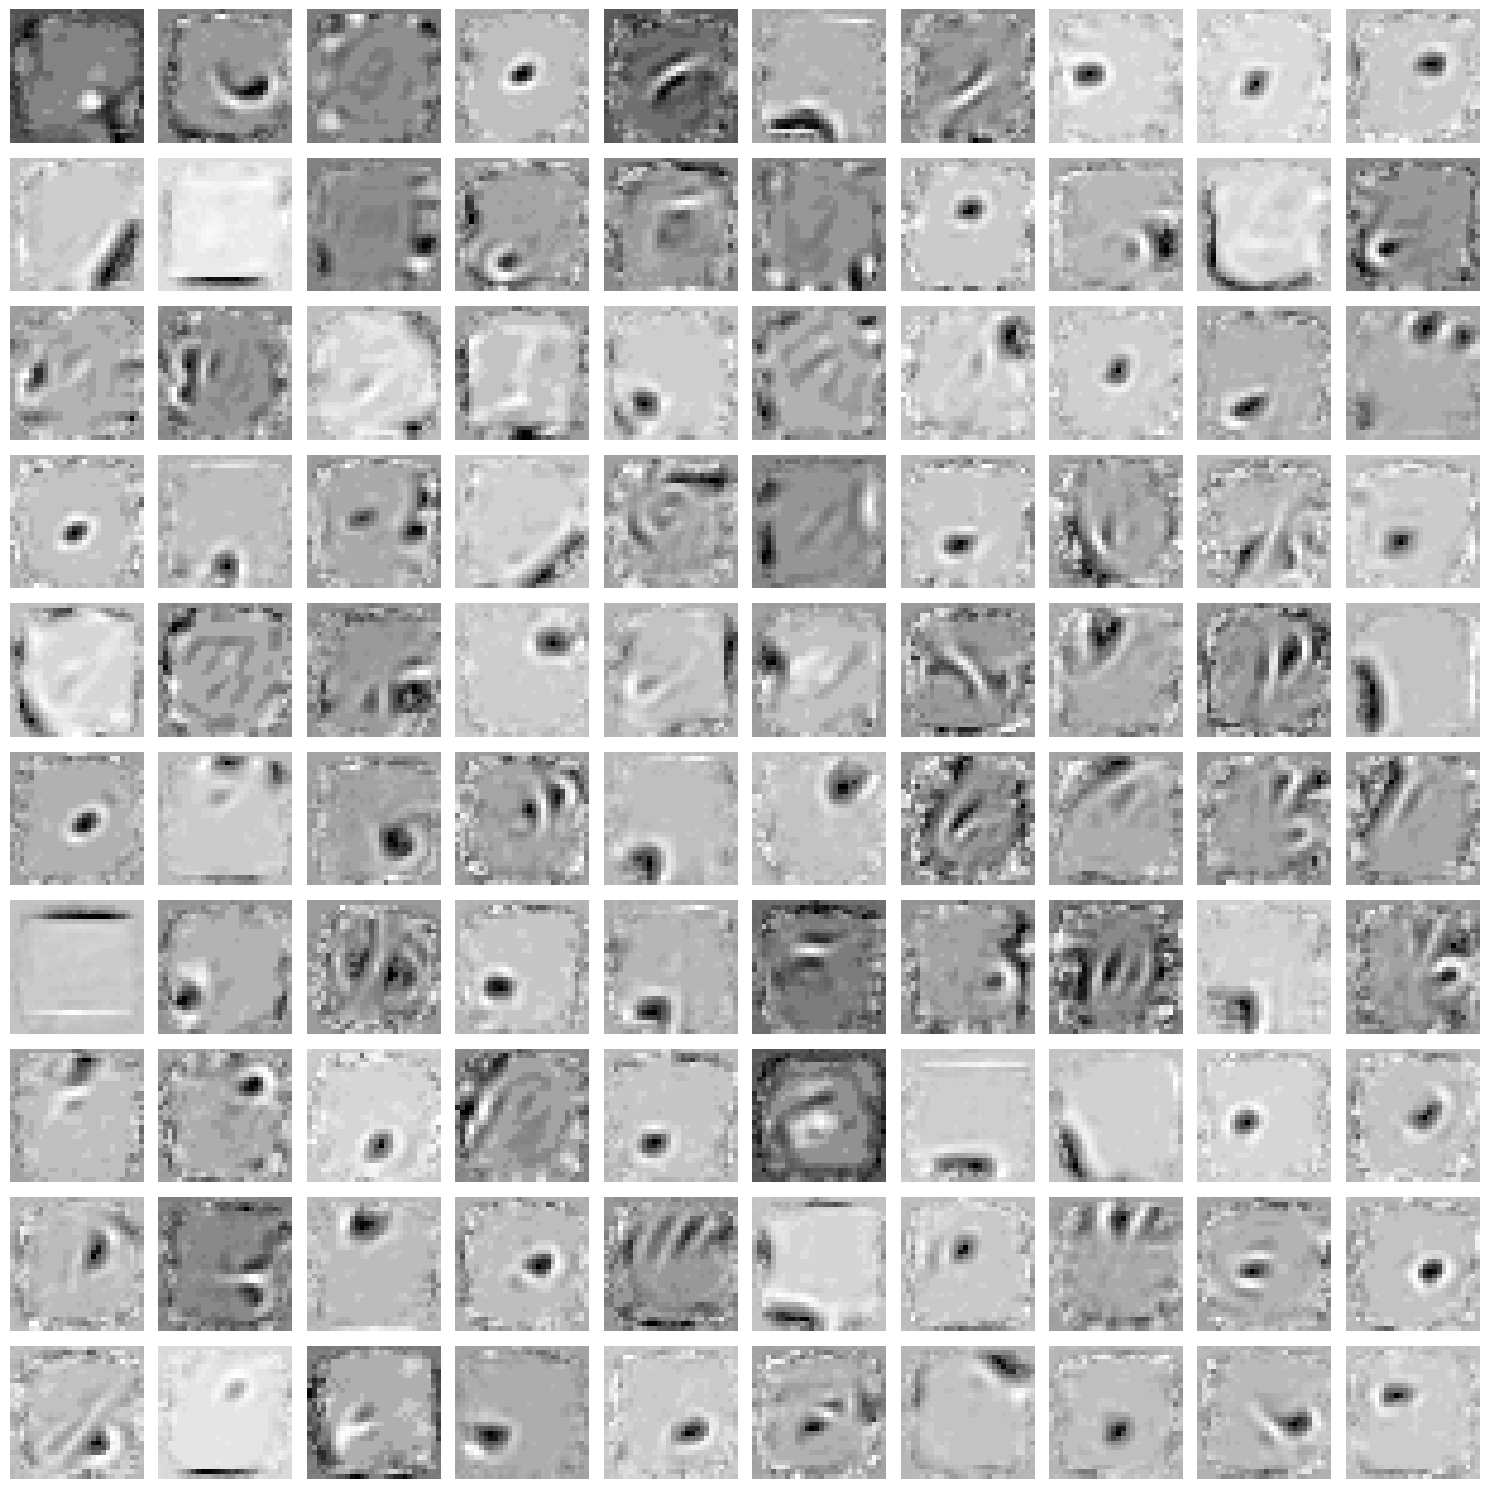


======= Layer 2 =======


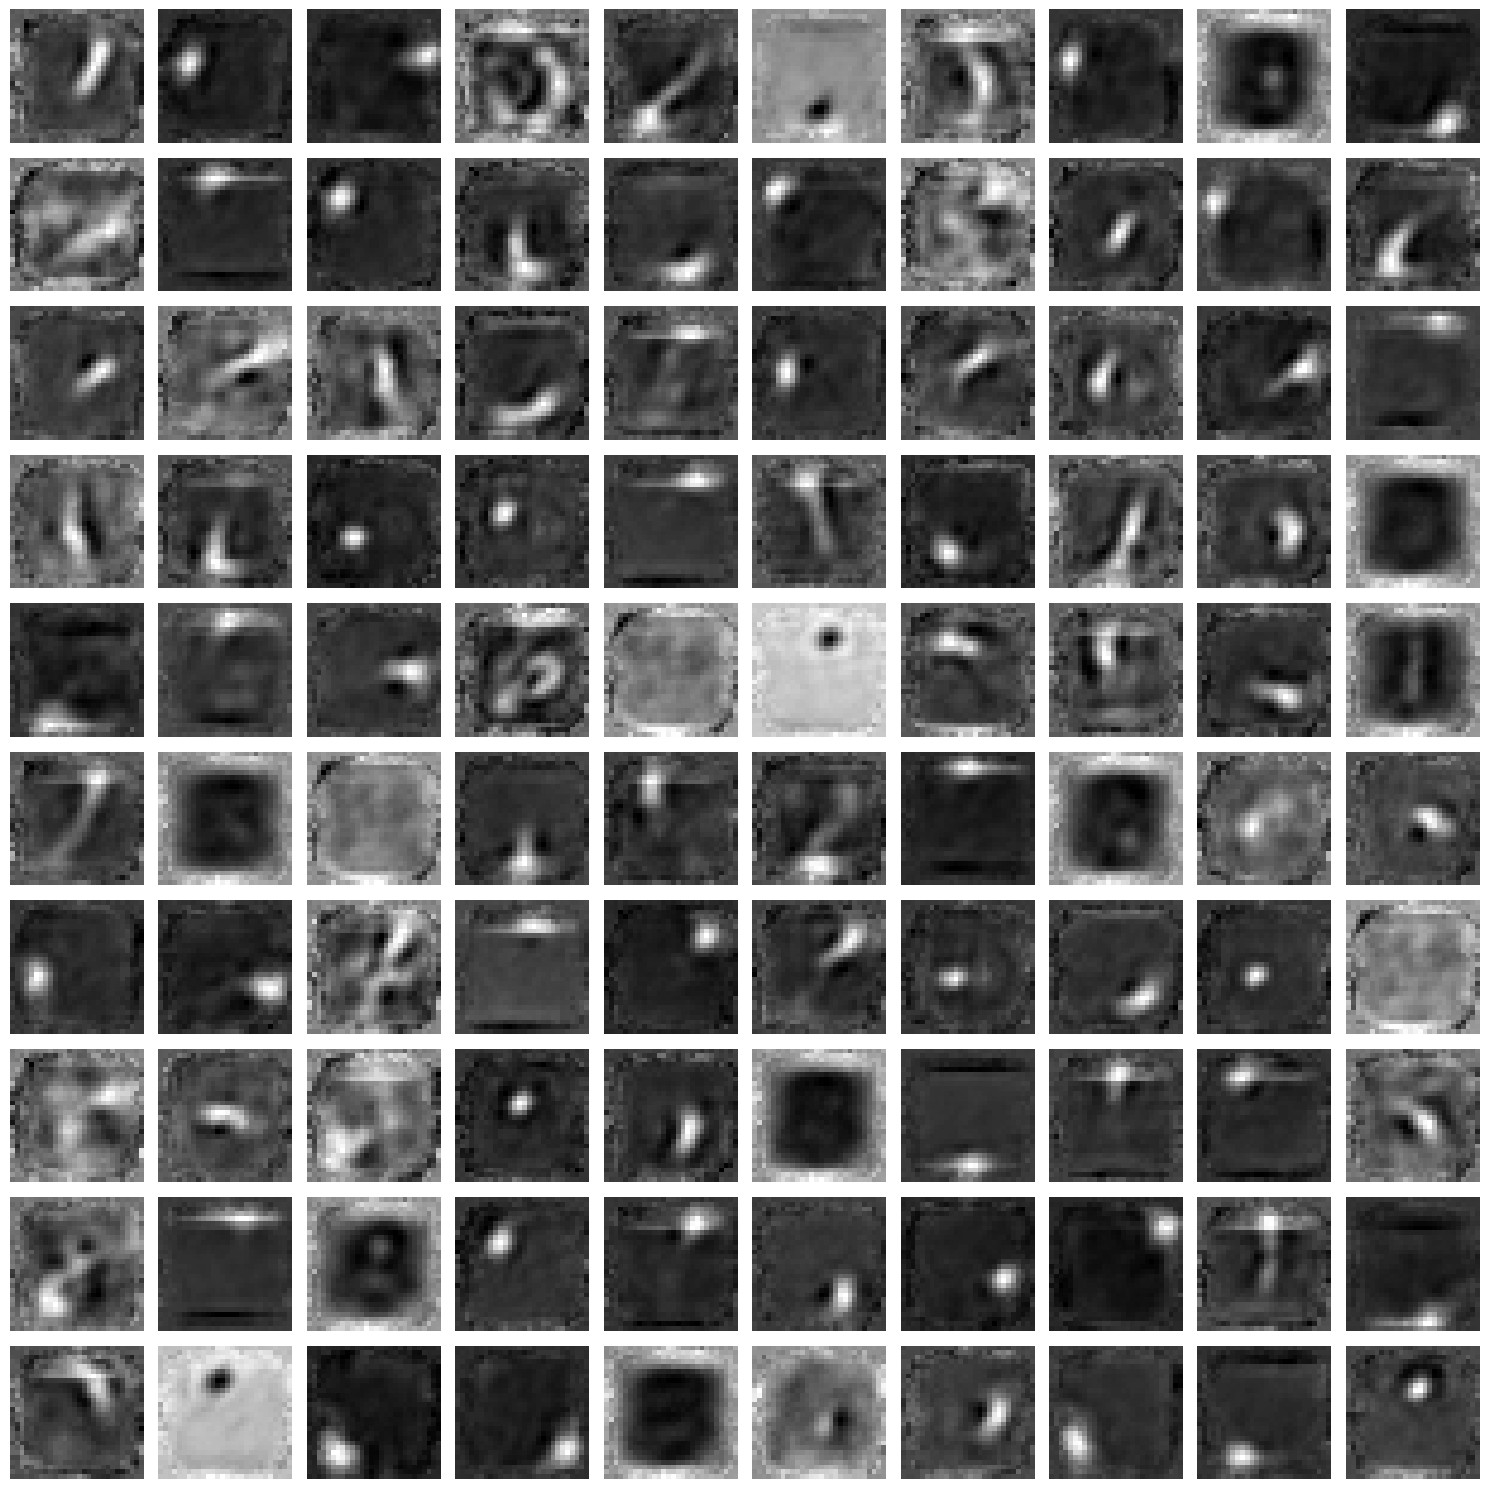


======= Layer 3 =======


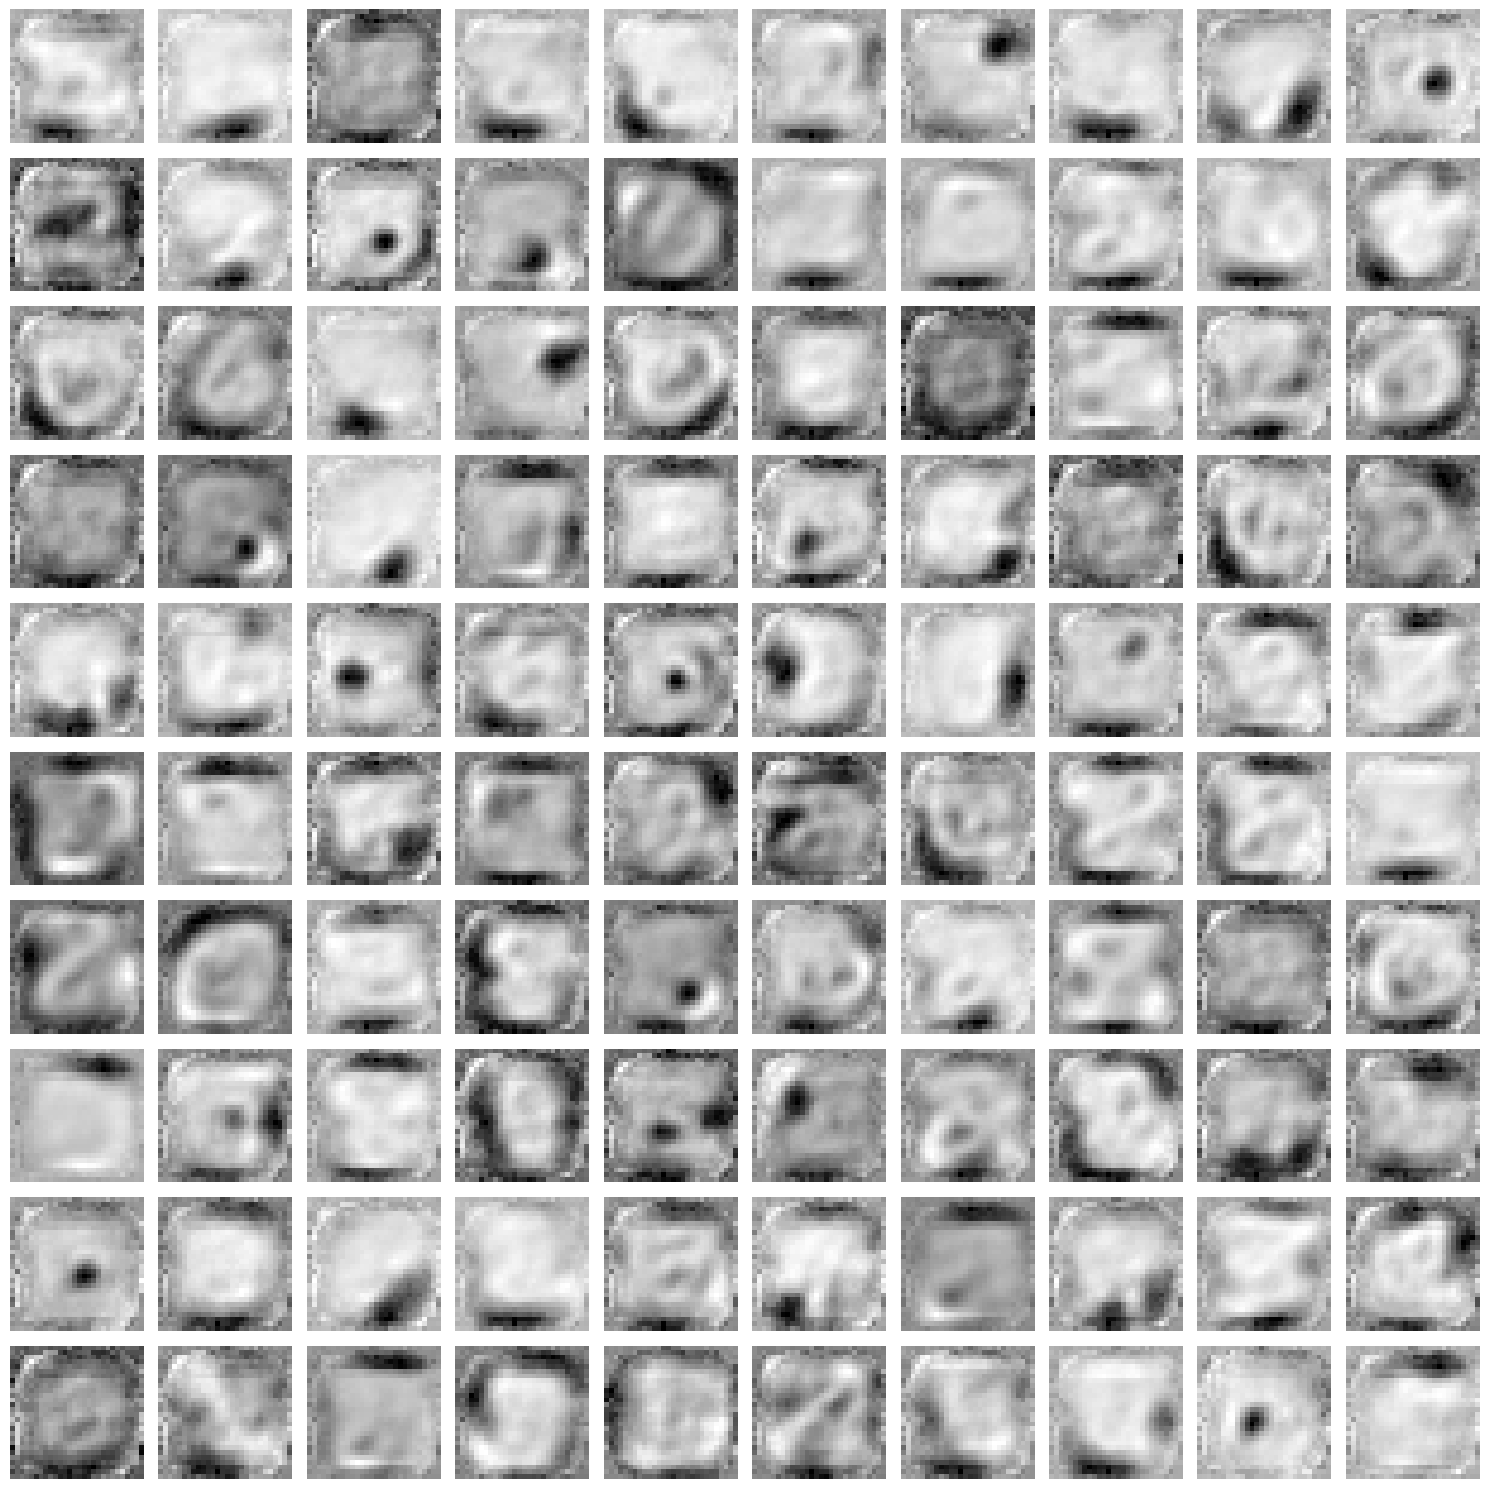

In [42]:
weights_prod = None
for layer_idx, rbm in enumerate(dbn.rbms):
    layer_weights = get_rbm_weights(rbm)
    layer_weights = apply_threshold(layer_weights, 0.1)

    # Linear projection
    weights_prod = (
        weights_prod @ layer_weights.T
    ) if weights_prod is not None else layer_weights.T

    layer_weights = apply_min_max_scaler(weights_prod)

    print(f'======= Layer {layer_idx + 1} =======')
    plot_layer_receptive_fields(layer_weights)
    print()

## Clustering internal representations

In [43]:
def get_label_mask(labels, label):
    return labels == label


def get_mean_representations(representations, labels):
    return {
        label: np.mean(representations[get_label_mask(labels, label)], axis=0)
        for label in np.unique(labels)
    }


def show_dendrogram(representations, labels):
    mean_representations = get_mean_representations(representations, labels)
    representations_matrix = np.concatenate([
        np.expand_dims(mean_representations[label], axis=0)
        for label in np.unique(labels)
    ])

    fig, ax = plt.subplots()
    linkage = scipy.cluster.hierarchy.linkage(
        representations_matrix, method='complete'
    )
    dendrogram = scipy.cluster.hierarchy.dendrogram(linkage)

    plt.tight_layout()
    display(fig)
    plt.close(fig)


def show_clusters(representations, labels):
    mean_representations = get_mean_representations(representations, labels)
    unique_labels = sorted(mean_representations.keys())
    representations_matrix = np.concatenate([
        np.expand_dims(mean_representations[label], axis=0)
        for label in unique_labels
    ])

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(representations_matrix)

    fig, ax = plt.subplots()
    plt.scatter(pca_result[:, 0], pca_result[:, 1])

    for i, label in enumerate(unique_labels):
        plt.annotate(str(label), (pca_result[i, 0], pca_result[i, 1]))

    plt.tight_layout()
    display(fig)
    plt.close(fig)

======= Layer 1 =======


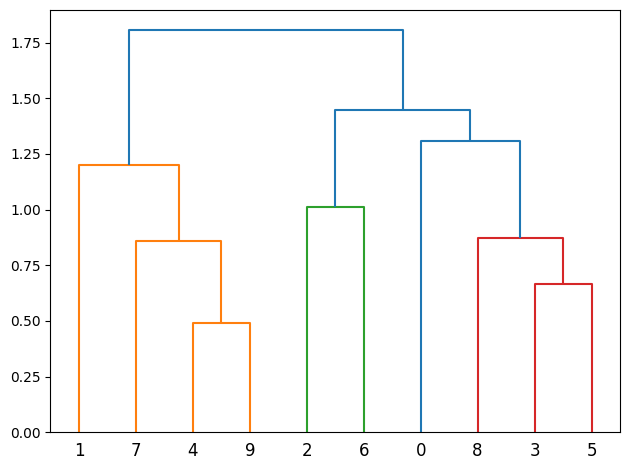

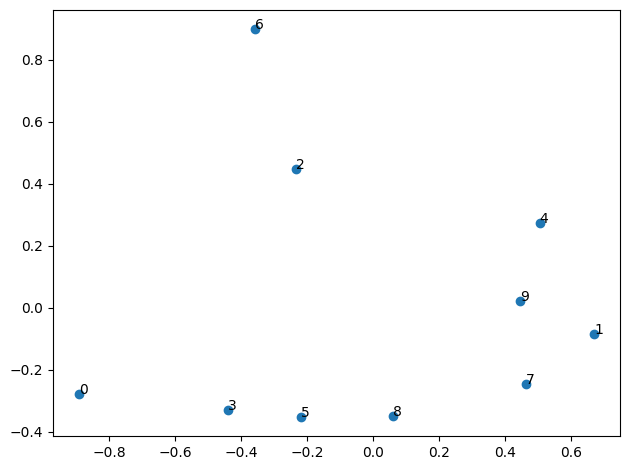


======= Layer 2 =======


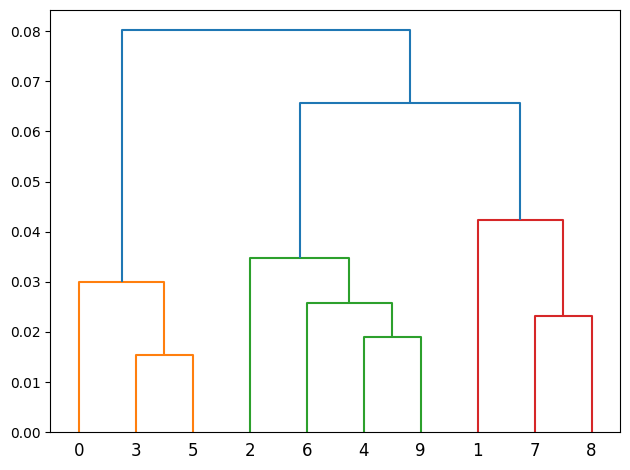

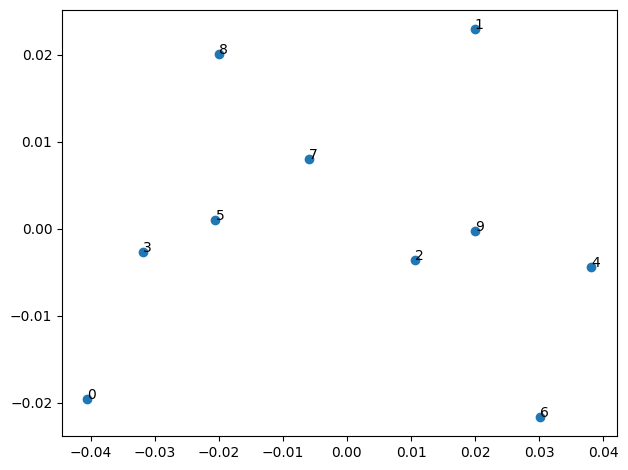


======= Layer 3 =======


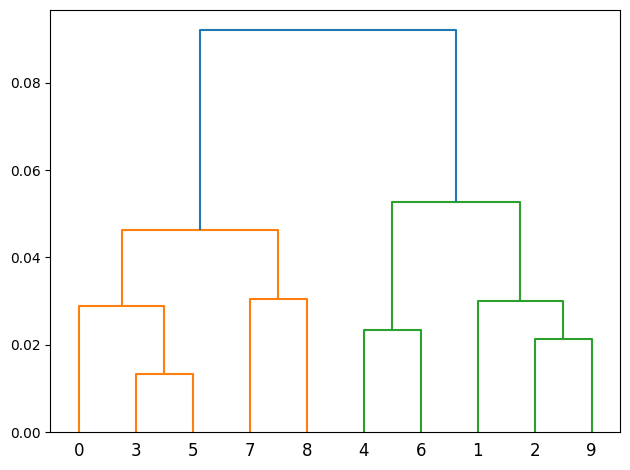

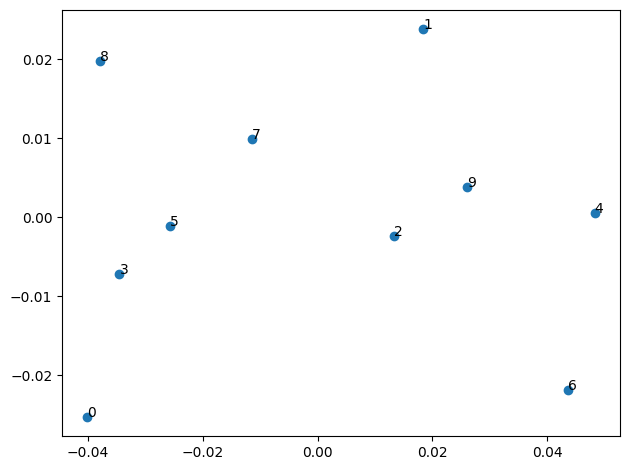

In [ ]:
labels = mnist_test_ds.targets.cpu().numpy()

prob_h = normalize_float(
    mnist_test_ds.data.reshape(len(mnist_test_ds), n_visible)
)
prob_h = prob_h.to(device)

for layer_idx, rbm in enumerate(dbn.rbms):
    prob_h, h = rbm.sample_h(prob_h)

    print(f'======= Layer {layer_idx + 1} =======')
    show_dendrogram(prob_h.cpu().numpy(), labels)
    show_clusters(prob_h.cpu().numpy(), labels)
    print()

## Linear read-out layer

In [ ]:
class LinearReadOutLayer(nn.Module):
    def __init__(self, n_input, n_output=10) -> None:
        super(LinearReadOutLayer, self).__init__()

        self.linear = nn.Linear(n_input, n_output)

    def forward(self, x):
        return self.linear(x)

In [46]:
linear_layers = []

for layer_idx, rbm in enumerate(dbn.rbms):
    n_input = rbm.W.shape[0]
    linear_layer = LinearReadOutLayer(n_input)
    linear_layer.to(device)

    linear_layers.append({
        'rbm': rbm,
        'linear_layer': linear_layer,
        'filename': f'linear_layer_{layer_idx+1}.pth'
    })

In [48]:
epochs = 1000

labels = mnist_train_ds.targets.to(device)

prob_h = normalize_float(
    mnist_train_ds.data.reshape(len(mnist_train_ds), n_visible)
)
prob_h = prob_h.to(device)

for layer_idx, linear_layer_dict in enumerate(linear_layers):

    print(f'======= Layer {layer_idx + 1} =======')

    linear_layer = linear_layer_dict['linear_layer']
    rbm = linear_layer_dict['rbm']
    filename = linear_layer_dict['filename']

    prob_h, h = rbm.sample_h(prob_h)

    optimizer = torch.optim.Adam(linear_layer.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = linear_layer(prob_h)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    torch.save(linear_layer.state_dict(), filename)

======= Layer 1 =======
Epoch 1/1000, Loss: 0.1556
Epoch 101/1000, Loss: 0.1220
Epoch 201/1000, Loss: 0.1052
Epoch 301/1000, Loss: 0.0943
Epoch 401/1000, Loss: 0.0865
Epoch 501/1000, Loss: 0.0805
Epoch 601/1000, Loss: 0.0758
Epoch 701/1000, Loss: 0.0720
Epoch 801/1000, Loss: 0.0688
Epoch 901/1000, Loss: 0.0660
Epoch 1000/1000, Loss: 0.0636
======= Layer 2 =======
Epoch 1/1000, Loss: 2.3026
Epoch 101/1000, Loss: 0.6391
Epoch 201/1000, Loss: 0.3848
Epoch 301/1000, Loss: 0.2924
Epoch 401/1000, Loss: 0.2437
Epoch 501/1000, Loss: 0.2129
Epoch 601/1000, Loss: 0.1913
Epoch 701/1000, Loss: 0.1751
Epoch 801/1000, Loss: 0.1624
Epoch 901/1000, Loss: 0.1520
Epoch 1000/1000, Loss: 0.1434
======= Layer 3 =======
Epoch 1/1000, Loss: 2.3026
Epoch 101/1000, Loss: 0.6176
Epoch 201/1000, Loss: 0.3537
Epoch 301/1000, Loss: 0.2619
Epoch 401/1000, Loss: 0.2146
Epoch 501/1000, Loss: 0.1853
Epoch 601/1000, Loss: 0.1651
Epoch 701/1000, Loss: 0.1502
Epoch 801/1000, Loss: 0.1386
Epoch 901/1000, Loss: 0.1293
Epoc

In [72]:
# Downloading and loading weights from file
%%capture
_loaded_linear_layers = []
for linear_layer_dict in linear_layers:
    linear_layer = linear_layer_dict['linear_layer']
    filename = linear_layer_dict['filename']

    !wget -O {filename} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{filename}"

    linear_layer.load_state_dict(torch.load(filename, map_location=device))
    linear_layer.to(device)

    linear_layer_dict['linear_layer'] = linear_layer
    _loaded_linear_layers.append(linear_layer_dict)

linear_layers = _loaded_linear_layers

In [49]:
def test_linear_layers(linear_layer_dicts, test_ds, device=None, print_output=True):
    labels = test_ds.targets.to(device)

    accuracies = []

    prob_h = normalize_float(test_ds.data.reshape(len(test_ds), n_visible))
    for layer_idx, linear_layer_dict in enumerate(linear_layer_dicts):
        linear_layer = linear_layer_dict['linear_layer']
        rbm = linear_layer_dict['rbm']

        prob_h, h = rbm.sample_h(prob_h.to(device))

        outputs = linear_layer(prob_h)
        predictions = torch.argmax(outputs, dim=1)

        accuracy = (predictions == labels).sum().item() / len(labels)
        accuracies.append(accuracy)

        if print_output:
            print(f'Layer {layer_idx + 1}: accuracy = {accuracy}')

    return accuracies

In [50]:
linear_accuracies = test_linear_layers(
    linear_layer_dicts=linear_layers,
    test_ds=mnist_test_ds,
    device=device
)

Layer 1: accuracy = 0.9721
Layer 2: accuracy = 0.9633
Layer 3: accuracy = 0.9681


## Feed-Forward Network / Convolutional Neural Network

In [51]:
class FFN(nn.Module):
    def __init__(self, img_shape=mnist_img_shape, n_classes=10) -> None:
        super(FFN, self).__init__()

        n_input = img_shape[0] * img_shape[1]
        self.fc1 = nn.Linear(n_input, 400)
        self.fc2 = nn.Linear(400, 500)
        self.fc3 = nn.Linear(500, 800)
        self.fc4 = nn.Linear(800, n_classes)

    def forward(self, x):
        x = x.flatten(1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = self.fc4(x)

        return output

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()

        self.conv_1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same')
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same')
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(3136, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.max_pool_1(x)

        x = self.conv_2(x)
        x = F.relu(x)
        x = self.max_pool_2(x)

        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        output = self.fc2(x)

        return output

In [53]:
ffn_model = FFN()

ffn_model.to(device)

test_idx = 5
test_batch = next(iter(mnist_test_loader))
test_img, test_digit = test_batch[0][test_idx], test_batch[1][test_idx]

# Creating batch
test_img = test_img.unsqueeze(0)

ffn_model(test_img.to(device))
ffn_model(test_batch[0].to(device))

summary(ffn_model, mnist_img_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         314,000
            Linear-2                  [-1, 500]         200,500
            Linear-3                  [-1, 800]         400,800
            Linear-4                   [-1, 10]           8,010
Total params: 923,310
Trainable params: 923,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.52
Estimated Total Size (MB): 3.54
----------------------------------------------------------------


In [54]:
cnn_model = CNN()

cnn_model.to(device)

test_idx = 5
test_batch = next(iter(mnist_test_loader))
test_img, test_digit = test_batch[0][test_idx], test_batch[1][test_idx]

# Creating batch
test_img = test_img.unsqueeze(0)

cnn_model(test_img.to(device))
cnn_model(test_batch[0].to(device))

summary(cnn_model, (1, mnist_img_shape[0], mnist_img_shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 256]         803,072
            Linear-6                   [-1, 10]           2,570
Total params: 824,458
Trainable params: 824,458
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 3.15
Estimated Total Size (MB): 3.51
----------------------------------------------------------------


In [55]:
def train_model(
    model, train_loader, optimizer_cls, criterion_cls,
    optimizer_params={}, criterion_params={}, epochs=10,
    device=None, filename=None,
    checkpoint_freq=5, checkpoint_dir=None, checkpoint_filename=None
):
    model.to(device)

    start_epoch = 0

    optimizer = optimizer_cls(model.parameters(), **optimizer_params)
    criterion = criterion_cls(**criterion_params)

    if checkpoint_filename is not None:
        if os.path.exists(checkpoint_filename):
            checkpoint = torch.load(checkpoint_filename, map_location=device)

            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            loss = checkpoint['loss']

            # Override optimizer params
            for group in optimizer.param_groups:
                for k, v in optimizer_params.items():
                    if k != 'params':
                        group[k] = v

            print(f'Resumed from epoch {start_epoch}, Loss: {loss:.4f}')

    for epoch in range(start_epoch, epochs):
        model.train()

        running_loss = 0.0
        n_samples = 0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)

            bs = data.size(0)
            running_loss += loss.item() * bs
            n_samples += bs

            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / n_samples

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

        if checkpoint_dir and (epoch + 1) % checkpoint_freq == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'{filename}_check_{epoch+1}.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }, checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

    if filename is not None:
        torch.save(model.state_dict(), filename)
        print(f'Model weights saved to "{filename}"')

    return model


def load_model(model, filename, download=True, from_checkpoint=False, device=None):

    if download:
        !wget -O {filename} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{filename}"

    state_file = torch.load(filename, map_location=device)
    if from_checkpoint:
        model.load_state_dict(state_file['model_state_dict'])
    else:
        model.load_state_dict(state_file)

    model.to(device)
    print(f'Model weights loaded from "{filename}"')
    return model


def test_model(
    model, test_loader, criterion_cls, criterion_params={}, device=None,
    print_output=True
):
    model.to(device)
    model.eval()

    criterion = criterion_cls(**criterion_params)

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            bs = data.size(0)
            running_loss += loss.item() * bs
            total += bs

            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()

    test_loss = running_loss / total
    accuracy = correct / total

    if print_output:
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    return test_loss, accuracy

In [56]:
# Initializing FFN
optimizer_cls = torch.optim.Adam
optimizer_params = {'lr': 0.0005}
criterion_cls = nn.CrossEntropyLoss
criterion_params = {}

ffn_filename = 'ffn_model.pth'

In [57]:
# Training FFN
ffn_model = train_model(
    model=FFN(),
    optimizer_cls=optimizer_cls,
    criterion_cls=criterion_cls,
    optimizer_params=optimizer_params,
    criterion_params=criterion_params,
    train_loader=mnist_train_loader,
    epochs=20,
    device=device,
    filename=ffn_filename,
    # checkpoint_freq=10,
    # checkpoint_dir='checkpoints',
    # checkpoint_filename='checkpoints/ffn_model.pth_check_10.pth'
)

Epoch 1/20, Loss: 0.2952
Epoch 11/20, Loss: 0.0372
Epoch 20/20, Loss: 0.0253
Model weights saved to "ffn_model.pth"


In [104]:
# Loading FFN
%%capture
ffn_model = load_model(
    model=FFN(),
    filename=ffn_filename,
    download=True,
    from_checkpoint=False,
    device=device
)

In [61]:
# Testing FFN
_, _ = test_model(
    model=ffn_model,
    test_loader=mnist_test_loader,
    criterion_cls=criterion_cls,
    criterion_params=criterion_params,
    device=device
)

Test Loss: 0.0824, Test Accuracy: 0.9815


In [62]:
# Initializing CNN
optimizer_cls = torch.optim.Adam
optimizer_params = {'lr': 0.001}
criterion_cls = nn.CrossEntropyLoss
criterion_params = {}

cnn_filename = 'cnn_model.pth'

In [63]:
# Training CNN
cnn_model = train_model(
    model=CNN(),
    optimizer_cls=optimizer_cls,
    criterion_cls=criterion_cls,
    optimizer_params=optimizer_params,
    criterion_params=criterion_params,
    train_loader=mnist_train_loader,
    epochs=20,
    device=device,
    filename=cnn_filename,
    # checkpoint_freq=10,
    # checkpoint_dir='checkpoints',
    # checkpoint_filename='checkpoints/cnn_model.pth_check_10.pth'
)

Epoch 1/20, Loss: 0.1106
Epoch 11/20, Loss: 0.0045
Epoch 20/20, Loss: 0.0035
Model weights saved to "cnn_model.pth"


In [ ]:
# Loading CNN
%%capture
cnn_model = load_model(
    model=CNN(),
    filename=cnn_filename,
    download=True,
    from_checkpoint=False,
    device=device
)

In [66]:
# Testing CNN
_, _ = test_model(
    model=cnn_model,
    test_loader=mnist_test_loader,
    criterion_cls=criterion_cls,
    criterion_params=criterion_params,
    device=device
)

Test Loss: 0.0635, Test Accuracy: 0.9900


## Robustness to noise

In [ ]:
def inject_noise(data, noise_level=0.1):
    noise = torch.randn_like(data) * noise_level
    noisy_data = data + noise
    return noisy_data


def inject_mnist_noise(base_ds, train_flag: bool, noise_level=0.1):
    noisy_ds = torchvision.datasets.MNIST(
        root=base_ds.root,
        train=train_flag,
        download=False,
        transform=base_ds.transform,
        target_transform=base_ds.target_transform
    )
    noisy_ds.data = inject_noise(
        base_ds.data.clone(), noise_level=noise_level).clamp(0, 1)
    noisy_ds.targets = base_ds.targets.clone()
    return noisy_ds


def plot_noise_robustness_curve(noise_levels, accuracy_values):
    pass

In [ ]:
noise_level = 0.3

noise_train_ds = inject_mnist_noise(mnist_train_ds, train_flag=True,  noise_level=noise_level)
noise_test_ds = inject_mnist_noise(mnist_test_ds,  train_flag=False, noise_level=noise_level)

noise_train_loader = DataLoader(noise_train_ds, batch_size=batch_size, shuffle=True)
noise_test_loader = DataLoader(noise_test_ds,  batch_size=batch_size, shuffle=False)

The image shows the digit: 5


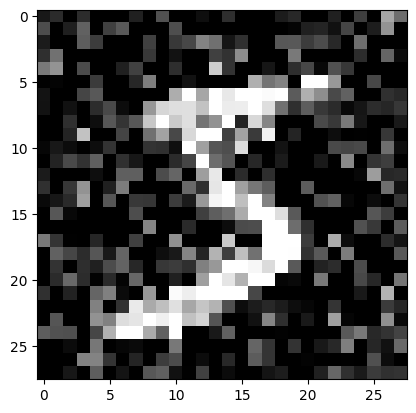

In [89]:
idx = 0
img = noise_train_ds.data[idx]
digit = noise_train_ds.targets[idx]

show_img(img, digit)

In [99]:
linear_accuracies = test_linear_layers(
    linear_layer_dicts=linear_layers,
    test_ds=noise_test_ds,
    device=device,
    print_output=False
)

print(linear_accuracies)

[0.3801, 0.2664, 0.128]


In [106]:
criterion_cls = nn.CrossEntropyLoss
criterion_params = {}

_, ffn_accuracy = test_model(
    model=ffn_model,
    test_loader=noise_test_loader,
    criterion_cls=criterion_cls,
    criterion_params=criterion_params,
    device=device,
    print_output=False
)

print(ffn_accuracy)

0.1114


## Adversarial attacks

# Task
Analyze the robustness of the FFN, CNN, and DBN models to noise by implementing functions to inject noise, calculate model accuracy, and plot accuracy curves across various noise levels to compare their performance.

## Implement calculate_accuracy

### Subtask:
Define a helper function `calculate_accuracy` that takes a model and a data loader as input, and returns the accuracy of the model on the provided data.


**Reasoning**:
I need to define a helper function `calculate_accuracy` that takes a model, a data loader, and a device as input, and returns the accuracy of the model on the provided data, as described in the instructions.



In [ ]:
def calculate_accuracy(model, data_loader, device=None):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            predictions = torch.argmax(outputs, dim=1)

            correct += (predictions == targets).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy
